In [10]:
# IN jupyter, shift+r will change output bar to the right side of the code bar, care.
# Use capslock to type captial letter "R"!!!!

# MobileNet
Loading pretrained model MobileNetV3Small


In [1]:
import os,gc,time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.backend import clear_session

RANDOM_SEED = 2023 # random seed for k-fold cross-validation
BATCH_SIZE = 16  
EPOCH_NUM = 50
FOLD_NUM = 5
num_channels = 3 # number of channels = 3: RGB
image_size = (224, 224) # set image size

# early stop metrics monitoring validation loss, in order to compare models, set all epoch=50 fixed, not used now.
#early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#early_stopping_accuracy = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#CALLBACKS = [early_stopping_loss, early_stopping_accuracy]

# set CUDA environment variables
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # use GPU0
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # reduce potential conflict of packages
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true" # GPU memory management

# set data dir
data_dir = "./data/merged_aug_data_224"
#train_dir = "./data/aug_data_224/Train"
#test_dir = "./data/aug_data_224/Test"

# set folder address, avoid duplicated directory name
model_weights_dir = './models/MobileNet'
model_id = 0
while os.path.exists(model_weights_dir):
    model_id += 1
    model_weights_dir = f'./models/MobileNet{model_id}/'
if not os.path.exists(model_weights_dir):
    os.makedirs(model_weights_dir)

# save all configurations in a txt file
with open(os.path.join(model_weights_dir, 'info.txt'), 'w') as file:
    variables = {
        'RANDOM_SEED': RANDOM_SEED,
        'BATCH_SIZE': BATCH_SIZE,
        'EPOCH_NUM': EPOCH_NUM,
        'FOLD_NUM': FOLD_NUM,
        'num_channels': num_channels,
        'image_size': image_size,
        #'monitor of early_stopping_loss':early_stopping_loss.monitor,
        #'patience of early_stopping_loss':early_stopping_loss.patience,
        #'restore_best_weights of early_stopping_loss':early_stopping_loss.restore_best_weights,
        #'monitor of early_stopping_accuracy': early_stopping_loss.monitor,
        #'patience of early_stopping_accuracy': early_stopping_loss.patience,
        #'restore_best_weights of early_stopping_accuracy': early_stopping_loss.restore_best_weights,
        'CUDA_VISIBLE_DEVICES': os.environ["CUDA_VISIBLE_DEVICES"],
        'KMP_DUPLICATE_LIB_OK': os.environ["KMP_DUPLICATE_LIB_OK"],
        'TF_FORCE_GPU_ALLOW_GROWTH': os.environ['TF_FORCE_GPU_ALLOW_GROWTH'],
        'data_dir:' : data_dir
        #'train_dir': train_dir,
        #'test_dir': test_dir
    }
    for variable, value in variables.items():
        file.write(f'{variable} = {value}\n')
print('Model weights have been saved at：', model_weights_dir)

Model weights have been saved at： ./models/MobileNet3/


# Design the model

In [2]:
def create_model(input_shape, num_classes):
    # Create a Sequential model
    model = Sequential()
    
    # Add a normalization layer to preprocess input data
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
    
    # Load MobileNetV3Small model (excluding top classification layers)
    mobilenet_model = MobileNetV3Small(weights='imagenet', input_shape=input_shape, include_top=False)
    
    # Add a Global Average Pooling layer to reduce spatial dimensions
    x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_model.output)
    
    # Add a Dense layer for classification with softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Compile the model
    model = Model(inputs=mobilenet_model.input, outputs=predictions)
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Loading datasets

In [3]:
#Load training set and test set, and their labels
def load_images_and_labels(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                #image = tf.cast(image, tf.float16) / 255.0 # normalize, out of memeory
                #image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    return np.array(images), np.array(labels)

In [4]:
# Get training set and test set, and their label
images, labels = load_images_and_labels(data_dir)

loading images from ./data/merged_aug_data_224\Mild


100%|██████████████████████████████████████████████████████████████████████████| 11200/11200 [00:07<00:00, 1435.00it/s]


loading images from ./data/merged_aug_data_224\Moderate


100%|██████████████████████████████████████████████████████████████████████████| 16372/16372 [00:11<00:00, 1392.28it/s]


loading images from ./data/merged_aug_data_224\Non


100%|██████████████████████████████████████████████████████████████████████████| 12800/12800 [00:08<00:00, 1430.77it/s]


# Training the model with 5-fold cross-validation

Use StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=RANDOM_SEED) to split training set into 5 folds.

    

In [5]:
def get_checkpoint_for_fold(model_id):
    '''
    return checkpoint for each fold of cross-validation
    select the model with the lowest validation loss
    '''
    checkpoint = ModelCheckpoint(model_weights_dir + f'/best_model_{model_id}.h5', 
                                 monitor='val_loss',
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='min',
                                 verbose=2)
    return checkpoint

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
def test_model(model, test_images, test_labels):
    # use data in test set to make predictions
    test_probabilities = model.predict(test_images)
    test_predictions = np.argmax(test_probabilities, axis=1)

    # calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    confusion_mat = confusion_matrix(test_labels, test_predictions)
    weighted_auc_ovr = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovr')
    #print(weighted_auc_ovr)
    weighted_auc_ovo = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovo')
    #print(weighted_auc_ovo)
    print(f'Test set performance:')
    print("Weighted AUC(OvR):", weighted_auc_ovr)
    print("Weighted AUC(OvO):", weighted_auc_ovo)
    print(f'Weighted F1 score = {f1}')
    print(f'Weighted Precision = {precision}, Weighted Recall = {recall}, Accuracy = {accuracy}')
    print('Confusion matrix:\n')
    print(confusion_mat)

    # get the result of classification report
    report = classification_report(test_labels, test_predictions)
    print(f'Result of classification report:\n')
    print(report)
    return f1, weighted_auc_ovr, weighted_auc_ovo

training on fold 0:
Epoch 1/50
1615/1615 [==============================] - 107s 60ms/step - loss: 0.5840 - accuracy: 0.7392 - val_loss: 0.8371 - val_accuracy: 0.7467

Epoch 00001: val_loss improved from inf to 0.83713, saving model to ./models/MobileNet3\best_model_0.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 94s 58ms/step - loss: 0.2617 - accuracy: 0.8967 - val_loss: 1.7034 - val_accuracy: 0.7161

Epoch 00002: val_loss did not improve from 0.83713
Epoch 3/50
1615/1615 [==============================] - 95s 59ms/step - loss: 0.1437 - accuracy: 0.9476 - val_loss: 0.6737 - val_accuracy: 0.8286

Epoch 00003: val_loss improved from 0.83713 to 0.67371, saving model to ./models/MobileNet3\best_model_0.h5
Epoch 4/50
1615/1615 [==============================] - 94s 58ms/step - loss: 0.1017 - accuracy: 0.9652 - val_loss: 0.3936 - val_accuracy: 0.8793

Epoch 00004: val_loss improved from 0.67371 to 0.39362, saving model to ./models/MobileNet3\best_model_0.h5
Epoch 5/50
1615/1615 [==============================] - 93s 57ms/step - loss: 0.0852 - accuracy: 0.9699 - val_loss: 0.9514 - val_accuracy: 0.8246

Epoch 00005: val_loss did not improve from 0.39362
Epoch 6/50
1615/1615 [==============================] - 94s 58ms/step - loss: 0.0662 - accurac

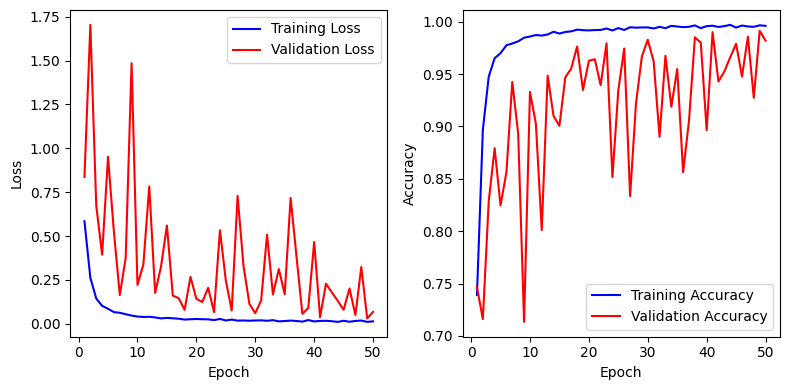

training on fold 1:
Epoch 1/50
1615/1615 [==============================] - 95s 57ms/step - loss: 0.5964 - accuracy: 0.7369 - val_loss: 1.6120 - val_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 1.61197, saving model to ./models/MobileNet3\best_model_1.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 91s 56ms/step - loss: 0.2682 - accuracy: 0.8955 - val_loss: 0.4471 - val_accuracy: 0.8611

Epoch 00002: val_loss improved from 1.61197 to 0.44713, saving model to ./models/MobileNet3\best_model_1.h5
Epoch 3/50
1615/1615 [==============================] - 89s 55ms/step - loss: 0.1459 - accuracy: 0.9469 - val_loss: 1.4586 - val_accuracy: 0.7509

Epoch 00003: val_loss did not improve from 0.44713
Epoch 4/50
1615/1615 [==============================] - 90s 56ms/step - loss: 0.1069 - accuracy: 0.9628 - val_loss: 0.4321 - val_accuracy: 0.8774

Epoch 00004: val_loss improved from 0.44713 to 0.43215, saving model to ./models/MobileNet3\best_model_1.h5
Epoch 5/50
1615/1615 [==============================] - 91s 56ms/step - loss: 0.0835 - accuracy: 0.9695 - val_loss: 0.4921 - val_accuracy: 0.8664

Epoch 00005: val_loss did not improve from 0.43215
Epoch 6/50
1615/1615 [==============================] - 89s 55ms/step - loss: 0.0716 - accurac

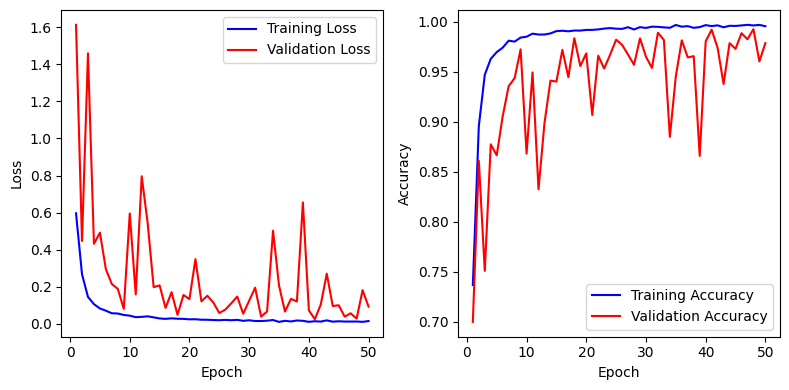

training on fold 2:
Epoch 1/50
1615/1615 [==============================] - 95s 57ms/step - loss: 0.6158 - accuracy: 0.7283 - val_loss: 1.7157 - val_accuracy: 0.6644

Epoch 00001: val_loss improved from inf to 1.71570, saving model to ./models/MobileNet3\best_model_2.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 88s 54ms/step - loss: 0.2959 - accuracy: 0.8839 - val_loss: 0.9908 - val_accuracy: 0.7932

Epoch 00002: val_loss improved from 1.71570 to 0.99081, saving model to ./models/MobileNet3\best_model_2.h5
Epoch 3/50
1615/1615 [==============================] - 89s 55ms/step - loss: 0.1654 - accuracy: 0.9383 - val_loss: 0.4502 - val_accuracy: 0.8718

Epoch 00003: val_loss improved from 0.99081 to 0.45023, saving model to ./models/MobileNet3\best_model_2.h5
Epoch 4/50
1615/1615 [==============================] - 88s 55ms/step - loss: 0.1108 - accuracy: 0.9594 - val_loss: 0.2923 - val_accuracy: 0.9161

Epoch 00004: val_loss improved from 0.45023 to 0.29229, saving model to ./models/MobileNet3\best_model_2.h5
Epoch 5/50
1615/1615 [==============================] - 88s 54ms/step - loss: 0.0848 - accuracy: 0.9693 - val_loss: 2.3582 - val_accuracy: 0.7830

Epoch 00005: val_loss did not improve from 0.29229
Epoch 6/50
1615/1615 [===============

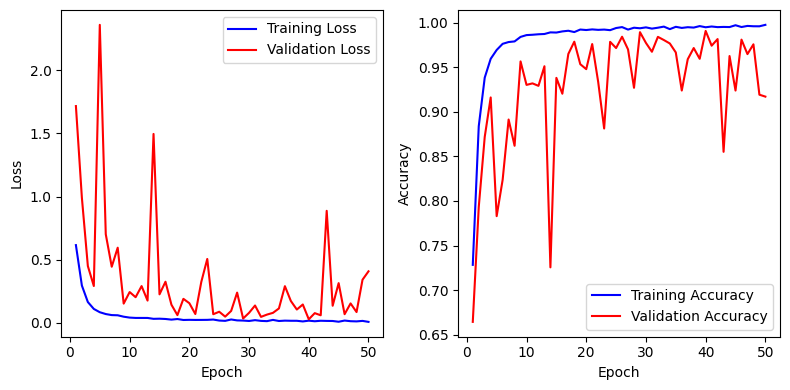

training on fold 3:
Epoch 1/50
1615/1615 [==============================] - 92s 55ms/step - loss: 0.6093 - accuracy: 0.7318 - val_loss: 2.1654 - val_accuracy: 0.6571

Epoch 00001: val_loss improved from inf to 2.16545, saving model to ./models/MobileNet3\best_model_3.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 87s 54ms/step - loss: 0.2783 - accuracy: 0.8931 - val_loss: 1.2557 - val_accuracy: 0.7937

Epoch 00002: val_loss improved from 2.16545 to 1.25565, saving model to ./models/MobileNet3\best_model_3.h5
Epoch 3/50
1615/1615 [==============================] - 87s 54ms/step - loss: 0.1496 - accuracy: 0.9457 - val_loss: 0.5622 - val_accuracy: 0.8342

Epoch 00003: val_loss improved from 1.25565 to 0.56217, saving model to ./models/MobileNet3\best_model_3.h5
Epoch 4/50
1615/1615 [==============================] - 87s 54ms/step - loss: 0.1045 - accuracy: 0.9630 - val_loss: 0.6420 - val_accuracy: 0.8296

Epoch 00004: val_loss did not improve from 0.56217
Epoch 5/50
1615/1615 [==============================] - 88s 54ms/step - loss: 0.0837 - accuracy: 0.9703 - val_loss: 0.3014 - val_accuracy: 0.9130

Epoch 00005: val_loss improved from 0.56217 to 0.30142, saving model to ./models/MobileNet3\best_model_3.h5
Epoch 6/50
1615/1615 [===============

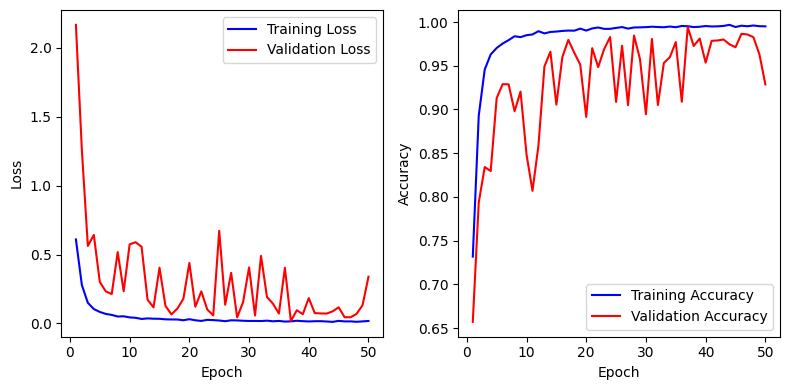

training on fold 4:
Epoch 1/50
1615/1615 [==============================] - 97s 58ms/step - loss: 0.6063 - accuracy: 0.7311 - val_loss: 1.2035 - val_accuracy: 0.7633

Epoch 00001: val_loss improved from inf to 1.20350, saving model to ./models/MobileNet3\best_model_4.h5


C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
1615/1615 [==============================] - 92s 57ms/step - loss: 0.2706 - accuracy: 0.8944 - val_loss: 0.3724 - val_accuracy: 0.8669

Epoch 00002: val_loss improved from 1.20350 to 0.37240, saving model to ./models/MobileNet3\best_model_4.h5
Epoch 3/50
1615/1615 [==============================] - 92s 57ms/step - loss: 0.1511 - accuracy: 0.9430 - val_loss: 2.2037 - val_accuracy: 0.6268

Epoch 00003: val_loss did not improve from 0.37240
Epoch 4/50
1615/1615 [==============================] - 92s 57ms/step - loss: 0.1050 - accuracy: 0.9620 - val_loss: 0.6217 - val_accuracy: 0.8627

Epoch 00004: val_loss did not improve from 0.37240
Epoch 5/50
1615/1615 [==============================] - 91s 57ms/step - loss: 0.0854 - accuracy: 0.9693 - val_loss: 0.3685 - val_accuracy: 0.8813

Epoch 00005: val_loss improved from 0.37240 to 0.36852, saving model to ./models/MobileNet3\best_model_4.h5
Epoch 6/50
1615/1615 [==============================] - 91s 56ms/step - loss: 0.0705 - accurac

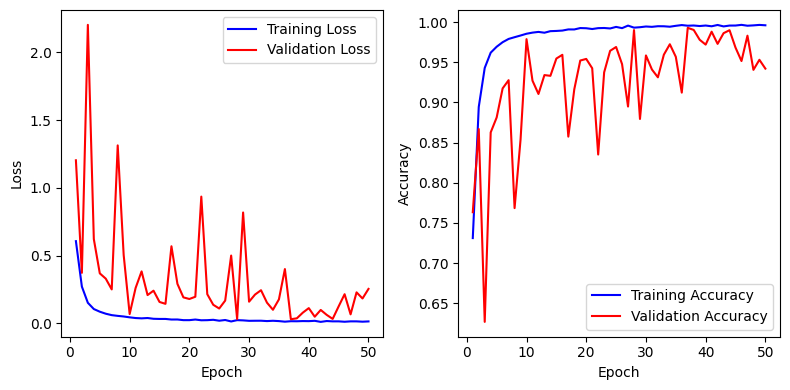

In [7]:
# memory leaking solved by adding gc.collect(), decreasing image size and batch size also helps.
# Following loop works with 32 Gib RAM PC
# set fold with a fixed random seed
kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=RANDOM_SEED)
val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
#accuracy_list = []
weighted_f1_list = []
auc_ovr_list = []
auc_ovo_list = []
#precision_list = []
#recall_list = []
fold_id = 0

# 5-fold cross-validation
for train_index_, test_index in  kf.split(images, labels):
    train_images_fold_, test_images_fold = images[train_index_], images[test_index]
    train_labels_fold_, test_labels_fold = labels[train_index_], labels[test_index]
    for train_index, val_index in val_split.split(train_images_fold_, train_labels_fold_):
        train_images_fold, val_images_fold = train_images_fold_[train_index], train_images_fold_[val_index] 
        train_labels_fold, val_labels_fold = train_labels_fold_[train_index], train_labels_fold_[val_index] 
    
    
    # get model
    model = create_model(input_shape=(image_size[0], image_size[1], num_channels), num_classes=3)

    best_epoch = get_checkpoint_for_fold(fold_id)
    
    # train the model
    print(f'training on fold {fold_id}:')
    history = model.fit(train_images_fold, train_labels_fold, 
                        epochs=EPOCH_NUM, 
                        batch_size=BATCH_SIZE,
                        #validation_split = 0.2,
                        validation_data=(val_images_fold, val_labels_fold),
                        callbacks=[best_epoch],
                        verbose=1)
    best_model_weight_dir = model_weights_dir + f'/best_model_{fold_id}.h5'

    if os.path.exists(best_model_weight_dir):
        #best_model = create_model(input_shape=(image_size[0], image_size[1], num_channels), num_classes=3)
        best_model = load_model(best_model_weight_dir)
        f1, auc_ovr, auc_ovo = test_model(model, test_images_fold, test_labels_fold)
        
        # store the values of metrics
        weighted_f1_list.append(f1)
        auc_ovr_list.append(auc_ovr)
        auc_ovo_list.append(auc_ovo)

        #move on for next fold
        fold_id += 1

    # get training history
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Get Loss-epoch plot
    num_epochs = len(loss)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy changes with epoch plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), accuracy, label='Training Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # releases the memory when there are many models in a loop
    try:
        del model, history, train_images_fold, test_images_fold, train_labels_fold, test_labels_fold
    except Exception as e:
        print(f"fail to release memory")
        print(f"Error message: {e}")
    # finnish a full collection
    gc.collect()
    clear_session()
    

In [8]:
print('Result of 5-fold Cross-validation on Test set data:')
print(f'weighted f1 score :{weighted_f1_list}\n')
print(f'Average of weighted auc OvR in 5 folds: {np.mean(auc_ovr_list)}')
print(f'Variance of weighted auc OvR in 5 folds: {np.var(auc_ovr_list)}')
print(f'Average of weighted auc OvO in 5 folds: {np.mean(auc_ovo_list)}')
print(f'Variance of weighted auc OvO in 5 folds: {np.var(auc_ovo_list)}')
print(f'Average of weighted F1 Score in 5 folds: {np.mean(weighted_f1_list)}')
print(f'Variance of Weighted F1 Score in 5 folds: {np.var(weighted_f1_list)}')

#print(f'Average Precision: { np.mean(precision_list)}')
#print(f'Variance of Precision: {np.var(precision_list)}')

#print(f'Average Recall: {np.mean(recall_list)}')
#print(f'Variance of Recall: {np.var(recall_list)}')

Result of 5-fold Cross-validation on Test set data:
weighted f1 score :[0.9771615031633871, 0.9746324107451938, 0.916455960208708, 0.928828629225148, 0.9458290634718942]

Average of weighted auc OvR in 5 folds: 0.9945562448075422
Variance of weighted auc OvR in 5 folds: 1.947694390151957e-05
Average of weighted auc OvO in 5 folds: 0.9943645024601425
Variance of weighted auc OvO in 5 folds: 2.024377708715391e-05
Average of weighted F1 Score in 5 folds: 0.9485815133628662
Variance of Weighted F1 Score in 5 folds: 0.0005850537298087038


# Refit the model with the best performed weight in 5 folds.


In [11]:
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in test_split.split(images, labels):
    train_images, test_images = images[train_index], images[test_index] 
    train_labels, test_labels = labels[train_index], labels[test_index] 
best_model_id = weighted_f1_list.index(max(weighted_f1_list))
best_model = load_model(model_weights_dir + f'/best_model_{best_model_id}.h5')
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
best_model.fit(train_images, train_labels, epochs=100, batch_size=BATCH_SIZE,callbacks=[early_stopping], verbose=1)
test_model(best_model, test_images, test_labels)
best_model.save_weights(model_weights_dir + f'/refit_best_model.h5')#not right, only save weights

Epoch 1/100
2019/2019 [==============================] - 136s 66ms/step - loss: 0.0169 - accuracy: 0.9943
Epoch 2/100
2019/2019 [==============================] - 132s 65ms/step - loss: 0.0158 - accuracy: 0.9953
Epoch 3/100
2019/2019 [==============================] - 131s 65ms/step - loss: 0.0117 - accuracy: 0.9969
Epoch 4/100
2019/2019 [==============================] - 132s 65ms/step - loss: 0.0154 - accuracy: 0.9954
Epoch 5/100
2019/2019 [==============================] - 131s 65ms/step - loss: 0.0127 - accuracy: 0.9961
Epoch 6/100
2019/2019 [==============================] - 131s 65ms/step - loss: 0.0165 - accuracy: 0.9956
Epoch 7/100
2019/2019 [==============================] - 131s 65ms/step - loss: 0.0110 - accuracy: 0.9968
Epoch 8/100
2019/2019 [==============================] - 131s 65ms/step - loss: 0.0101 - accuracy: 0.9972
Epoch 9/100
2019/2019 [==============================] - 131s 65ms/step - loss: 0.0126 - accuracy: 0.9956
Epoch 10/100
2019/2019 [======================

In [13]:
best_model.save(model_weights_dir + f'/final_best_model.h5')

C:\DevTools\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Test results analysis of models.

## Some conclusions
- The blocks above shows that both 3 classes gets balanced performance in these 5 folds of cross-validation.
- Model 0 performances best in validation dataset and also best in test set.
- In the confusion matrix, the off-diagonal values ​​are all small, indicating that the model misclassifies between classes relatively rarely.
## Further study
- The goal of 5-fold cross-validation is to evaluate the performance of pre-trained model MobileNetV3, actually not all the data in training set is used for training in the same time.
- Also, in order to test the generalization ability and robustness of the model, the number of samples in the test set may be increased through data augmentation.

# Sensitive analysis with shuffled labels and shuffled images

## Test with Shuffled Labels
Shuffle the labels of test dataset, use models trained from normal data. 

In [14]:
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1024)
for train_index, test_index in test_split.split(images, labels):
    train_images, test_images = images[train_index], images[test_index] 
    train_labels, test_labels = labels[train_index], labels[test_index] 
np.random.shuffle(test_labels)
model_x_dir = model_weights_dir + f'/final_best_model.h5'
model_x = load_model(model_x_dir)
test_model(model_x, test_images, test_labels)

Test set performance:
Weighted AUC(OvR): 0.49962626418128797
Weighted AUC(OvO): 0.49922309636402273
Weighted F1 score = 0.33777533730723724
Weighted Precision = 0.3377192438402379, Weighted Recall = 0.3378328173374613, Accuracy = 0.3378328173374613
Confusion matrix:

[[ 616  907  717]
 [ 887 1326 1062]
 [ 726 1048  786]]
Result of classification report:

              precision    recall  f1-score   support

           0       0.28      0.28      0.28      2240
           1       0.40      0.40      0.40      3275
           2       0.31      0.31      0.31      2560

    accuracy                           0.34      8075
   macro avg       0.33      0.33      0.33      8075
weighted avg       0.34      0.34      0.34      8075



(0.33777533730723724, 0.49962626418128797, 0.49922309636402273)

- In all 5 folds, Weighted AUC is close to 0.5, which means that the prediction is a random prediction.
- The 'macro avg' of accuracy is close to 0.33, when the difference of number and performance between classes is not considered.
- Therefore, when shuffle labels, the model rarely works, which means the model concentrate more on the texture and structure of the images.

## Test with shuffle pixels
According to the confusion matrix, the process of classification is destroyed completely, all images are randomly classified into one or two classes.

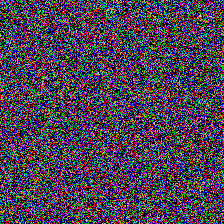

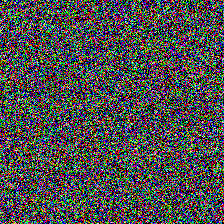

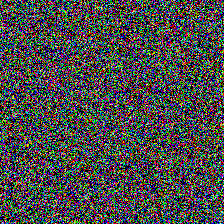

Test set performance:
Weighted AUC(OvR): 0.534031619100551
Weighted AUC(OvO): 0.5315758524205558
Weighted F1 score = 0.1642636109354942
Weighted Precision = 0.35177498134712937, Weighted Recall = 0.3195046439628483, Accuracy = 0.3195046439628483
Confusion matrix:

[[  22   28 2190]
 [  29   25 3221]
 [  17   10 2533]]
Result of classification report:

              precision    recall  f1-score   support

           0       0.32      0.01      0.02      2240
           1       0.40      0.01      0.01      3275
           2       0.32      0.99      0.48      2560

    accuracy                           0.32      8075
   macro avg       0.35      0.34      0.17      8075
weighted avg       0.35      0.32      0.16      8075



(0.1642636109354942, 0.534031619100551, 0.5315758524205558)

In [15]:
from IPython.display import display, Image
import cv2
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2048)
for train_index, test_index in test_split.split(images, labels):
    train_images, test_images = images[train_index], images[test_index] 
    train_labels, test_labels = labels[train_index], labels[test_index] 

import numpy as np

num_images, height, width, num_channels = test_images.shape

random_indices = np.arange(height * width)

for i in range(num_images):
    for j in range(num_channels):
        np.random.shuffle(random_indices)
        test_images[i, :, :, j] = test_images[i, :, :, j].reshape(-1)[random_indices].reshape((height, width))

for i in range(3):
    pred = test_images[i]
    # Convert image data to uint8
    pred = np.array(pred, np.uint8)
    # Display the image after pixel shuffled
    display(Image(data=cv2.imencode('.png', pred)[1].tobytes()))

model_x_dir = model_weights_dir + f'/final_best_model.h5'
model_x = load_model(model_x_dir)
test_model(model_x, test_images, test_labels)

#print(test_labels)
#for i in range(0,5): 
#    model_id = i
#    print(f'model{model_id} selected:')
#    model_x_dir =model_weights_dir + f'/best_model_{model_id}.h5'
#    model_x = load_model(model_x_dir)
#    test_shuffle_model(model_x, test_images, test_labels)

# Train with shuffled labels

In [ ]:
import os,gc,time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.backend import clear_session

def load_shuffled_label(directory):
    '''
    modified from the function above
    '''
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                #image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    shuffled_idx = np.arange(len(labels))
    np.random.shuffle(shuffled_idx)
    shuffled_labels = np.array(labels)[shuffled_idx]

    return np.array(images), shuffled_labels

def load_shuffled_pixel(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        print(f'loading images from {class_dir}')
        for filename in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, filename)
            try:
                image = cv2.imread(image_path)
                for channel in range(image.shape[2]):
                    channel_data = image[:, :, channel]
                    flat_channel_data = channel_data.ravel()#flat the 2-dimension array into 1-dimension
                    np.random.shuffle(flat_channel_data)
                    image[:, :, channel] = flat_channel_data.reshape(channel_data.shape) # reshape the picture
                images.append(image)
                labels.append(class_names.index(class_name))
            except Exception as e:
                print(f"Error loading image: {image_path}")
                print(f"Error message: {e}")
    return np.array(images), np.array(labels)
    
def train_shuffle_model(model, train_images, train_labels, epoch_num, batch_size):
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=0.2, random_state=2023)
    history = model.fit(train_images, train_labels, 
                        epochs=epoch_num, 
                        batch_size=batch_size,
                        validation_data=(val_images, val_labels),
                        #callbacks=[best_epoch],
                        verbose=2)
        # get predicitons of validation set 
    val_probabilities = model.predict(val_images)
    val_predictions = np.argmax(val_probabilities, axis=1)
    # get training history
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Get Loss-epoch plot
    num_epochs = len(loss)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy changes with epoch
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), accuracy, label='Training Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def test_shuffle_model(model, test_images, test_labels):
    # use data in test set to make predictions
    test_probabilities = model.predict(test_images)
    test_predictions = np.argmax(test_probabilities, axis=1)

    # calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    confusion_mat = confusion_matrix(test_labels, test_predictions)
    weighted_auc = roc_auc_score(test_labels, test_probabilities, average='weighted',multi_class='ovr')
    print(f'Test set performance:')
    print("Weighted AUC:", weighted_auc)
    print(f'Accuracy = {accuracy}, Weighted F1 score = {f1}')
    print(f'Weighted Precision = {precision}, Weighted Recall = {recall}')
    print('Confusion matrix:\n')
    print(confusion_mat)

    # get the result of classification report
    report = classification_report(test_labels, test_predictions)
    print(f'Model {model_id} - result of classification report:\n')
    print(report)